In [1]:
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
import os 


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/Users/kshitijberi/Documents/GitHub/langraph_chatbot_doj/env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
os.environ["LANGCHAIN_API_KEY"] = "LANGCHAIN_API_KEY"
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
os.environ["LANGCHAIN_PROJECT"] = "LANGCHAIN_PROJECT"

In [4]:
from langchain.document_loaders import PyPDFDirectoryLoader

path = "/Users/kshitijberi/Desktop/sih"
loader = PyPDFDirectoryLoader(path)
data = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500 , chunk_overlap = 10)

text_chunk = text_splitter.split_documents(data)

/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4
Ignoring wrong pointing object 13 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 42 0 (offset 0)
Ignoring wrong pointing object 65 0 (offset 0)
Ignoring wrong pointing object 67 0 (offset 0)
Ignoring wrong pointing object 73 0 (offset 0)
Ignoring wrong pointing object 103 0 (offset 0)
Ignoring wrong pointing object 183 0 (offset 0)
Ignoring wrong pointing object 442 0 (offset 0)
Ignoring wrong pointing object 64 0 (offset 0)
Ignoring wrong pointing object 67 0 (offset 0)
Ignoring wrong pointing object 111 0 (offset 0)
Ignoring wrong pointing object 121 0

In [5]:
# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=text_chunk,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(model="ft:gpt-4o-mini-2024-07-18:personal:sihprototype:A0uEp8wI")

str_output = StrOutputParser()
prompt = PromptTemplate(
    template="{query}",
    input_variables=["query"],
)

chain = prompt | llm | str_output

/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [7]:
chain.invoke({"query":"hi how are you"})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


"I'm just a computer program, but thanks for asking! How can I assist you today?"

In [8]:
### Generate
LangSmith_API = "LangSmith_API"

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)



# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/langchain/hub.py:120: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]


In [9]:
### Retrieval Grader
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
import os



groq_api_key="groq_api_key"
llm1=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")


### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

    # Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
structured_llm_grader = llm1.with_structured_output(GradeDocuments)

retrieval_grader = grade_prompt | structured_llm_grader
question = "what is e_comitee"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(
/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/posthog/client.py:345: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().replace(tzinfo=tzutc())
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/kshitijberi

binary_score='yes'


/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/pydantic/main.py:1087: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', category=PydanticDeprecatedSince20)


In [10]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
#llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm1.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [11]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [12]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def model(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---model---")
    print("---HELLO--")
    question = state["question"]
    print(question)
    documents = state["documents"]
    question = state["question"]

    chat = chain.invoke({"query": question})

    return {"documents": documents, "question": question, "generation": chat}
    



def grade_answer(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK ANSWER---")
    question = state["question"]
    generation = state["generation"]

    score = answer_grader.invoke(
        {"question": question, "generation": generation}
    )
    grade = score.binary_score

    # Check question-answering
    
    if grade == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "not useful"
    

In [13]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("model", model)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate", generate)  # generatae

# Build graph
workflow.add_edge(START, "retrieve")

workflow.add_edge("model",END)
workflow.add_edge("retrieve", "generate")


workflow.add_conditional_edges(
    "generate",
    grade_answer,
    {
        "useful": END,
        "not useful": "model",
    },
)

# Compile
app = workflow.compile()

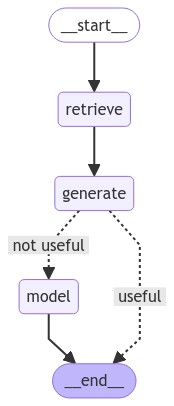

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
from pprint import pprint

# Run
inputs = {
    "question": "how many courts are there in  chandigarh "
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(end ="")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print(end = "")
        

# Final generation
print(value["generation"])

---RETRIEVE---
---GENERATE---


/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/pydantic/main.py:1087: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', category=PydanticDeprecatedSince20)


---CHECK ANSWER---


/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/pydantic/main.py:1087: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', category=PydanticDeprecatedSince20)


---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
---model---
---HELLO--
how many courts are there in  chandigarh 
8


/Users/kshitijberi/Documents/codes/llmmcq/env/lib/python3.12/site-packages/pydantic/main.py:1087: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', category=PydanticDeprecatedSince20)
